In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [36]:
df= pd.read_csv("train.csv")

In [37]:
df.head(100)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...,...
95,95,2013-01-01,11,PREPARED FOODS,0.0,0
96,96,2013-01-01,11,PRODUCE,0.0,0
97,97,2013-01-01,11,SCHOOL AND OFFICE SUPPLIES,0.0,0
98,98,2013-01-01,11,SEAFOOD,0.0,0


In [38]:
df.shape

(3000888, 6)

In [39]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [40]:
df.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [41]:
df["date"]=pd.to_datetime(df["date"])

In [42]:
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [43]:
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [44]:
daily_sales = (
    df
    .groupby("date", as_index=False)["sales"]
    .sum()
)

In [45]:
daily_sales

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


In [46]:
daily_sales=daily_sales.rename(columns={"sales":"y"})

In [47]:
daily_sales.tail()

,date,y
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081
1683,2017-08-15,762661.935939


In [48]:
daily_sales.shape

(1684, 2)

In [49]:
daily_sales.head()

,date,y
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


In [50]:
daily_sales["date"].diff().value_counts().head()

date
1 days    1679
2 days       4
Name: count, dtype: int64

In [51]:
daily_sales = daily_sales.sort_values("date").reset_index(drop=True)

In [52]:
validation_days = 90
cutoff_date = daily_sales["date"].iloc[-validation_days]

Split the data

In [53]:
train_df = daily_sales[daily_sales["date"] < cutoff_date]
val_df = daily_sales[daily_sales["date"] >= cutoff_date]

In [54]:
print(train_df["date"].max())
print(val_df["date"].min())
print(len(train_df), len(val_df))

2017-05-17 00:00:00
2017-05-18 00:00:00
1594 90


In [55]:
train_feat = train_df.copy()
val_feat = val_df.copy()

In [56]:
for df_ in [train_feat, val_feat]:
    df_["day_of_week"] = df_["date"].dt.dayofweek
    df_["month"] = df_["date"].dt.month
    df_["day_of_month"] = df_["date"].dt.day
    df_["week_of_year"] = df_["date"].dt.isocalendar().week.astype(int)

In [57]:
X_train = train_feat.drop(columns=["date", "y"])
y_train = train_feat["y"]

X_val = val_feat.drop(columns=["date", "y"])
y_val = val_feat["y"]

In [58]:
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((90, 4), (90,))

In [59]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [60]:
model.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [61]:
y_pred = model.predict(X_val)

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae, rmse


(225979.17375055992, np.float64(260293.5094386187))

Visualize the data

In [63]:
plot_df = pd.concat([
    train_df.assign(type="Train"),
    val_df.assign(type="Actual")
])
val_pred_df = val_df.copy()
val_pred_df["y"] = y_pred
val_pred_df["type"] = "Forecast"

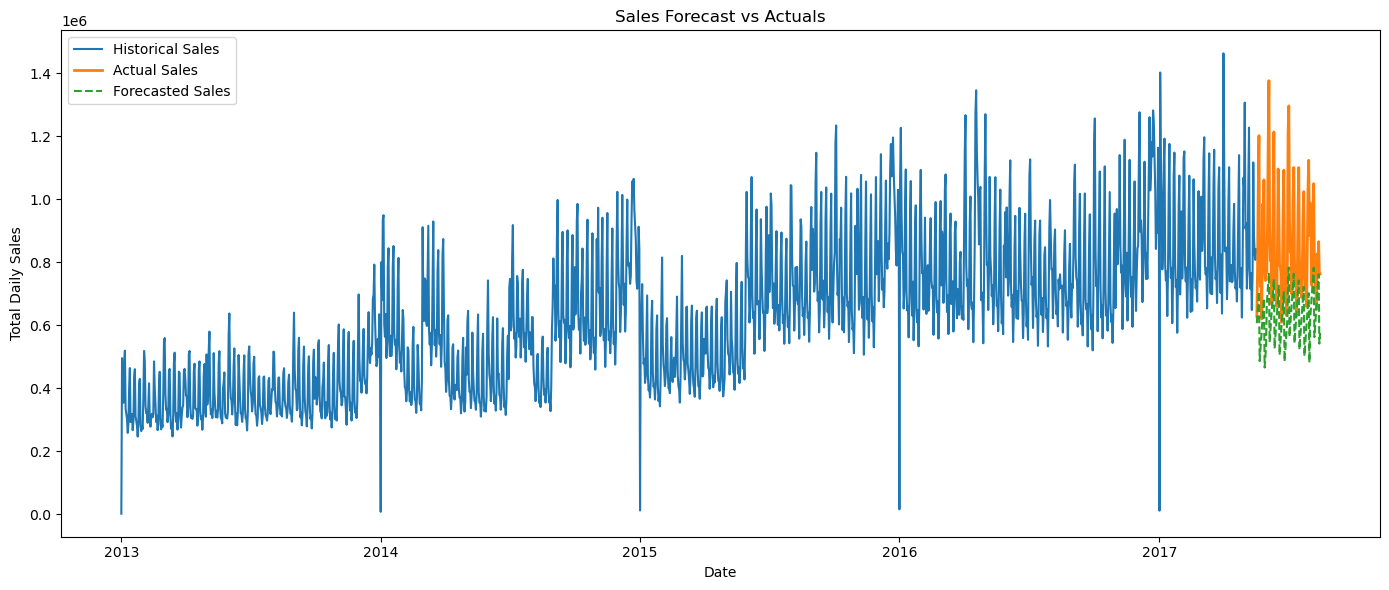

In [64]:
plt.figure(figsize=(14, 6))
plt.plot(
    train_df["date"],
    train_df["y"],
    label="Historical Sales"
)
plt.plot(
    val_df["date"],
    val_df["y"],
    label="Actual Sales",
    linewidth=2
)
plt.plot(
    val_df["date"],
    y_pred,
    label="Forecasted Sales",
    linestyle="--"
)
plt.xlabel("Date")
plt.ylabel("Total Daily Sales")
plt.title("Sales Forecast vs Actuals")
plt.legend()
plt.tight_layout()
plt.show()